In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from scipy.optimize import curve_fit
from glob import glob

In [4]:
# enter the path to the directory containing the images 
# for a2A4504-18ucBAS pixel mode is mono8
acq_list_12bit = glob("/Volumes/naat_sahu/machine_studies/PLI10/studies150524/light_source_preset/cpl-cpl/ccw/a2A4504-18ucBAS/Off/acq*/")
acq_list_12bit.sort(key=lambda x: int(x.split("/")[-2].split("_")[0].split("q")[-1]))

acq_list_12bit

['/Volumes/naat_sahu/machine_studies/PLI10/studies150524/light_source_preset/cpl-cpl/ccw/a2A4504-18ucBAS/Off/acq1_11000_1_1/',
 '/Volumes/naat_sahu/machine_studies/PLI10/studies150524/light_source_preset/cpl-cpl/ccw/a2A4504-18ucBAS/Off/acq2_11000_1_1.5/',
 '/Volumes/naat_sahu/machine_studies/PLI10/studies150524/light_source_preset/cpl-cpl/ccw/a2A4504-18ucBAS/Off/acq3_11000_1_2/',
 '/Volumes/naat_sahu/machine_studies/PLI10/studies150524/light_source_preset/cpl-cpl/ccw/a2A4504-18ucBAS/Off/acq4_11000_1_2.5/',
 '/Volumes/naat_sahu/machine_studies/PLI10/studies150524/light_source_preset/cpl-cpl/ccw/a2A4504-18ucBAS/Off/acq5_11000_1_3/',
 '/Volumes/naat_sahu/machine_studies/PLI10/studies150524/light_source_preset/cpl-cpl/ccw/a2A4504-18ucBAS/Off/acq6_11000_1_3.5/',
 '/Volumes/naat_sahu/machine_studies/PLI10/studies150524/light_source_preset/cpl-cpl/ccw/a2A4504-18ucBAS/Off/acq7_11000_1_3.999/',
 '/Volumes/naat_sahu/machine_studies/PLI10/studies150524/light_source_preset/cpl-cpl/ccw/a2A4504-18uc

In [7]:
def filter_acq_list(acq_list, mode= "none",value=0):
    acq_list_filtered = []
    if mode == "gain":
        for acq in acq_list:
            if float(acq.split("/")[-2].split("_")[2]) == value:
                acq_list_filtered.append(acq)
    elif mode == "exposure":
        for acq in acq_list:
            if float(acq.split("/")[-2].split("_")[1]) == value:
                acq_list_filtered.append(acq)

    elif mode == "gamma":
        for acq in acq_list:
            if float(acq.split("/")[-2].split("_")[3]) == value:
                acq_list_filtered.append(acq)
    
    elif mode == "gain_gamma":
        # value = (gain, gamma)
        # gain ,gamma = value[0], value[1]
        for acq in acq_list:
            if float(acq.split("/")[-2].split("_")[2]) == value[0] and float(acq.split("/")[-2].split("_")[3]) == value[1]:
                acq_list_filtered.append(acq)
    
    elif mode == "exposure_gain":
        # value = (exposure, gain)
        # gain ,gamma = value[0], value[1]
        for acq in acq_list:
            if float(acq.split("/")[-2].split("_")[1]) == value[0] and float(acq.split("/")[-2].split("_")[2]) == value[1]:
                acq_list_filtered.append(acq)
    
    elif mode == "exposure_gamma":
        # value = (exposure, gamma)
        # gain ,gamma = value[0], value[1]
        for acq in acq_list:
            if float(acq.split("/")[-2].split("_")[1]) == value[0] and float(acq.split("/")[-2].split("_")[3]) == value[1]:
                acq_list_filtered.append(acq)

    elif mode == "none":
        acq_list_filtered = acq_list

    return acq_list_filtered



def cal_mean_intensity(acq_list,mode="gain", value=0):
    
    acq_list_filtered = filter_acq_list(acq_list,mode, value)
    
    mean_intensities = []
    for acq in acq_list_filtered:
        img_list = glob(acq + "/*.png")
        mean_intensity = []
        for ind in range(len(img_list)):
            img_mean = io.imread(f"{acq}/{ind}.png").mean()
            mean_intensity.append(img_mean)
        label = acq.split("/")[-2].split("_")[0]
        mean_intensities.append((mean_intensity, label))

    return mean_intensities     

def phase(vals):
    n = len(vals)
    rho = np.linspace(0, (n-1)/n*2*np.pi, n).reshape(-1, 1)
    V = np.array(vals)
    R = np.hstack((np.ones((n, 1)), np.sin(2*rho), np.cos(2*rho)))
    a0, a1, b1 = np.linalg.lstsq(R, V.T, rcond=None)[0]
    ph = np.arctan2(b1, a1) * 90 / np.pi
    return ph

def inv_gamma(x,gamma):
    # print(x)
    for i in range(len(x)):
        # print(x[i], 255 * (x[i]/255)**(1/gamma))
        x[i] =255 * (x[i]/255)**(1/gamma)
    return x

def get_acq_info(label):

    acq = [acq for acq in acq_list_12bit if label in acq][0]
    acq_name = acq.split("/")[-2]
    exposure = float(acq_name.split("_")[1])
    gain = float(acq_name.split("_")[2])
    gamma = float(acq_name.split("_")[3])

    return acq_name, exposure, gain, gamma

def get_meanintensitybyanglevsgamma(acq_list,gammas,mode,value):
    mean_intensity = cal_mean_intensity(acq_list,mode,value)
    transposed_mean_int = np.zeros((len(gammas),len(mean_intensity[0][0])))

    for ind, mean_int in enumerate(mean_intensity):
        temp = np.array(mean_intensity[ind][0])
        transposed_mean_int[ind] = temp

    return transposed_mean_int

def get_meanintensitybyanglevsgain(acq_list,gains,mode,value):
    mean_intensity = cal_mean_intensity(acq_list,mode,value)
    trans = np.zeros((len(gains),len(mean_intensity[0][0])))
    for i in range(len(mean_intensity)):
        temps = inv_gamma(np.array(mean_intensity[i][0]),2)
        trans[i] = temps

    return trans



Text(0.5, 1.0, 'RGB images mean intensity vs angles for gain=1 by basler camera acA5472-17uc')

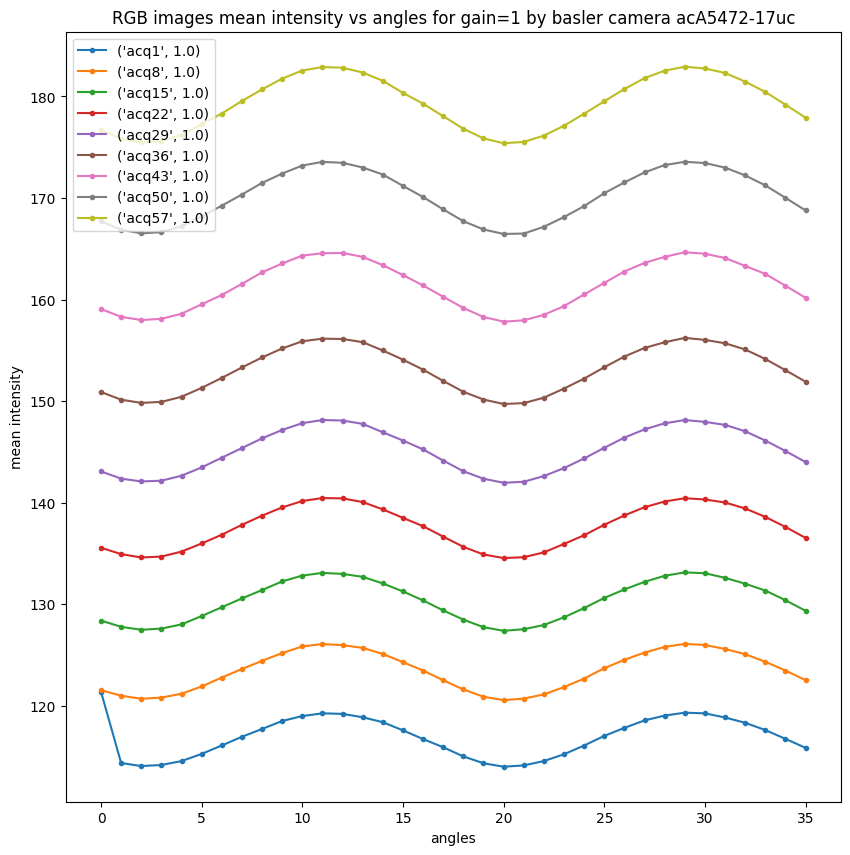

In [9]:

plt.figure(figsize=(10,10))
for mean_intensity in cal_mean_intensity(acq_list_12bit,"gamma",1):
    gamma = get_acq_info(mean_intensity[1])[3]
    plt.plot(inv_gamma(mean_intensity[0],gamma),'.-',label=(mean_intensity[1],gamma))
plt.legend()
plt.xlabel("angles")
plt.ylabel("mean intensity")
plt.title("RGB images mean intensity vs angles for gain=1 by basler camera acA5472-17uc")


In [10]:
mean_intensity = cal_mean_intensity(acq_list_12bit,"gamma",1)

acq1 1.0 1.0
acq8 1.0 2.0
acq15 1.0 3.0
acq22 1.0 4.0
acq29 1.0 5.0
acq36 1.0 6.0
acq43 1.0 7.0
acq50 1.0 8.0
acq57 1.0 9.0


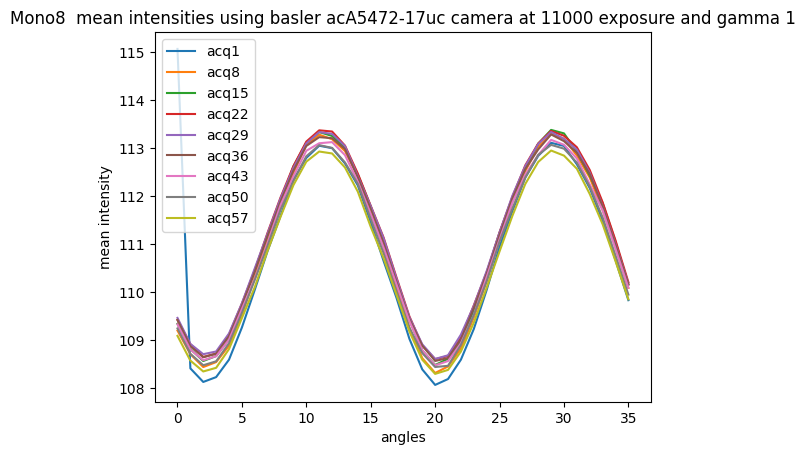

In [15]:
for mi, lable in mean_intensity:
    gamma = get_acq_info(lable)[3]
    gain = get_acq_info(lable)[2]
    print(lable,gamma,gain)

    plt.plot(np.divide(inv_gamma(mi,gamma),np.exp(gain/18.667)), label=lable)
    plt.legend()
    plt.xlabel("angles")
    plt.ylabel("mean intensity")
    plt.title("Mono8  mean intensities using basler acA5472-17uc camera at 11000 exposure and gamma 1")
    # plt.ylim(93.2,94.5)
    # plt.xlim(3,6)

In [16]:
def calculate_mse(image1, image2):
    return np.mean((image1 - image2) ** 2)

def calculate_psnr(image1, image2):
    mse = calculate_mse(image1, image2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0  
    return 20 * np.log10(max_pixel / np.sqrt(mse))

# calculate mse and psnr for the gamma corrected images by the index of the images
def calculate_mse_psnr_by_index(img1,img2):
    mse = calculate_mse(img1,img2)
    psnr = calculate_psnr(img1,img2)
    return mse,psnr

In [17]:
def inv_gain(x,gain):
    temp=np.zeros(len(x))
    for i in range(len(x)):
        temp[i] =np.divide(x[i], np.exp(gain/18.667))
    return temp

In [18]:
gamma_gain_corrected_mean_intensities_green_channel = []
for mi, lable in mean_intensity:
    gamma = get_acq_info(lable)[3]
    gain = get_acq_info(lable)[2]
    gamma_gain_corrected_mean_intensities_green_channel.append((inv_gain(inv_gamma(mi,gamma),gain),lable))

In [19]:
gamma_gain_corrected_mean_intensities_green_channel

[(array([115.0637377 , 108.4095124 , 108.12677729, 108.22769087,
         108.59143981, 109.26091032, 110.04808492, 110.86086765,
         111.58677515, 112.33281484, 112.79367946, 113.0474143 ,
         112.99682236, 112.67885552, 112.21988952, 111.4562429 ,
         110.64631434, 109.87861519, 109.02675414, 108.38841054,
         108.06491114, 108.1876692 , 108.59108368, 109.22950811,
         110.04355767, 110.94184148, 111.68932915, 112.38586805,
         112.83624561, 113.10760049, 113.0431479 , 112.66047495,
         112.16466333, 111.48829261, 110.66520009, 109.82987034]),
  'acq1'),
 (array([109.19736342, 108.70559414, 108.4373478 , 108.54085293,
         108.88371603, 109.52427776, 110.31610477, 111.06964503,
         111.79364784, 112.4819532 , 113.06529029, 113.27705548,
         113.1827756 , 112.93668523, 112.40498696, 111.67453828,
         110.93413524, 110.07584894, 109.26115564, 108.62215922,
         108.31338419, 108.4493833 , 108.82434769, 109.46976576,
         110

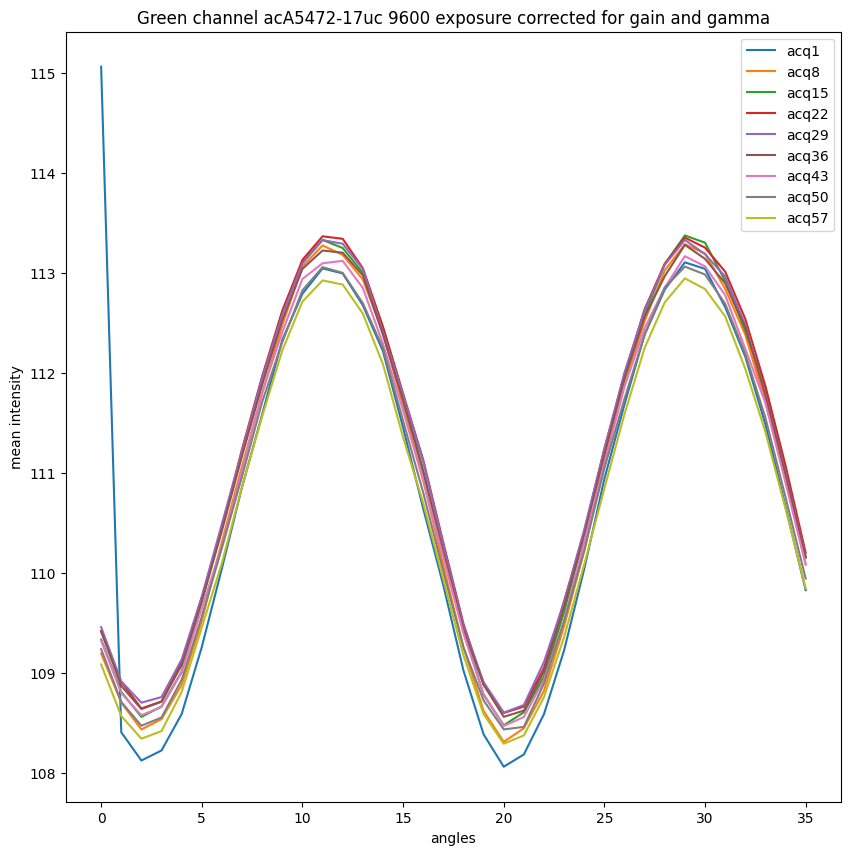

In [20]:
# plot the corrected mean intensities
plt.figure(figsize=(10,10))

for mi, lable in gamma_gain_corrected_mean_intensities_green_channel:
    plt.plot(mi, label=lable)
    plt.legend()
    plt.xlabel("angles")
    plt.ylabel("mean intensity")
    plt.title("Green channel acA5472-17uc 9600 exposure corrected for gain and gamma")
    # plt.ylim(93.2,94.5)
    # plt.xlim(3,6)

    

In [21]:
gamma_gain_corrected_mean_intensities_green_channel[0][0]

array([115.0637377 , 108.4095124 , 108.12677729, 108.22769087,
       108.59143981, 109.26091032, 110.04808492, 110.86086765,
       111.58677515, 112.33281484, 112.79367946, 113.0474143 ,
       112.99682236, 112.67885552, 112.21988952, 111.4562429 ,
       110.64631434, 109.87861519, 109.02675414, 108.38841054,
       108.06491114, 108.1876692 , 108.59108368, 109.22950811,
       110.04355767, 110.94184148, 111.68932915, 112.38586805,
       112.83624561, 113.10760049, 113.0431479 , 112.66047495,
       112.16466333, 111.48829261, 110.66520009, 109.82987034])

In [22]:
# calculate the mse and psnr between the images taking green[0] as the reference acquisition 
ref_acq = gamma_gain_corrected_mean_intensities_green_channel[0][0]
mse_by_acq=[]
psnr_by_acq=[]

for i in range(len(gamma_gain_corrected_mean_intensities_green_channel)):
    mse=[]
    psnr=[]
    for j in range(len(ref_acq)):
        mse_temp,psnr_temp = calculate_mse_psnr_by_index(ref_acq[j],gamma_gain_corrected_mean_intensities_green_channel[1][0][j])
        label = gamma_gain_corrected_mean_intensities_green_channel[i][1]
        mse.append(mse_temp)
        psnr.append((psnr_temp))
    mse_by_acq.append((mse, label))
    psnr_by_acq.append((psnr, label))
    

Text(0.5, 1.0, 'MSE between the reference image and the other images')

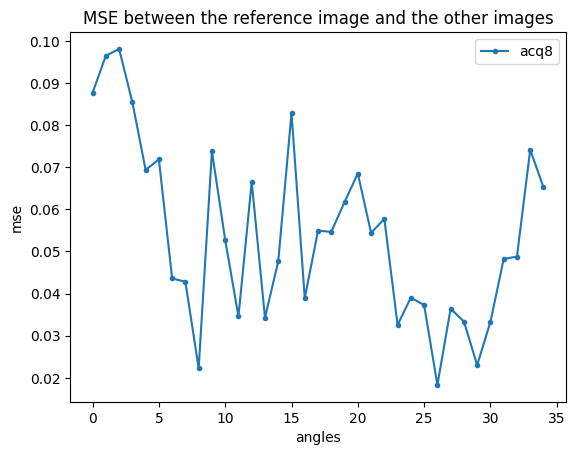

In [24]:
plt.plot(mse_by_acq[1][0][1:],'.-',label=f"{mse_by_acq[1][1]}")
plt.legend()
plt.xlabel("angles")
plt.ylabel("mse")
plt.title("MSE between the reference image and the other images")

Text(0.5, 1.0, 'MSE between the reference image and the other images')

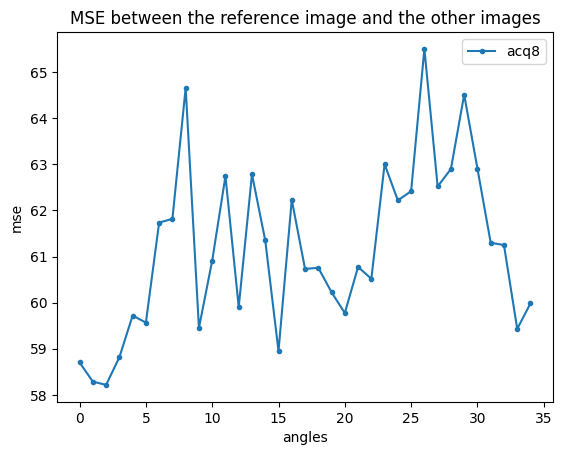

In [25]:
plt.plot(psnr_by_acq[1][0][1:],'.-',label=f"{mse_by_acq[1][1]}")
plt.legend()
plt.xlabel("angles")
plt.ylabel("mse")
plt.title("MSE between the reference image and the other images")